<a href="https://colab.research.google.com/github/Sergei-Volkov/CellsCounter/blob/main/NeuralNetworkTry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [101]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import os
import cv2 as cv
import albumentations as A

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [102]:
path = '/content/drive/MyDrive/Физтех/ООП проект/SyntheticCellsDataset'
os.chdir(path)

# Train & Test datasets

In [103]:
def get_files_names(path: str):
    files_images, files_masks = [], []
    for percent in ['00', '15', '30', '45', '60']:
        files_images_temp = next(os.walk(path + '/synthetic_0' + percent + '_images'))
        files_images += [files_images_temp[0] + '/' + name for name in sorted(files_images_temp[-1], key=lambda k: int(k[:-8]))]
        files_masks_temp = next(os.walk(path + '/synthetic_0' + percent + '_foreground'))
        files_masks += [files_masks_temp[0] + '/' + name for name in sorted(files_masks_temp[-1], key=lambda k: int(k[:-4]))]
    return np.array(files_images), np.array(files_masks)

In [104]:
X_train, X_test, Y_train, Y_test = train_test_split(
    *get_files_names(path),
    test_size=0.3,
    random_state=12345
)

# Batcher with augmentation

In [105]:
def strong_aug(input_size, p=0.7):
    return A.Compose([
        A.RandomCrop(input_size, input_size, always_apply=True),
        A.ShiftScaleRotate(shift_limit=10, scale_limit=0.2, rotate_limit=180, p=0.8),
        A.IAAAdditiveGaussianNoise(scale=(0.01, 0.05), p=1),
        # A.RandomBrightnessContrast(p=1),

    ], p=p)


def batch_generator(
    files_images: np.ndarray, 
    files_masks: np.ndarray, 
    batch_size: int, 
    input_size=256
    ):
    dataset_size = files_images.size
    while True:
        x_batch = []
        y_batch = []
        
        # берем рандомные пути к изображениям из нашего датасета и считываем их
        for i in np.random.randint(dataset_size, size=batch_size):
            img = cv.imread(files_images[i])
            mask = cv.imread(files_masks[i])

            # применяем аугментацию
            augmentation = strong_aug(input_size=input_size)  
            aug = augmentation(image=img.astype('uint8'), mask=mask)
            
            x_batch += [aug['image']]
            y_batch += [aug['mask'][..., 0]]

        # приводим числа к одному масштабу
        x_batch = np.array(x_batch) / 255.
        y_batch = np.array(y_batch)

        # у получился без 4 размерности, делаем ее искусственно 
        yield x_batch, np.expand_dims(y_batch, -1)

In [109]:
imgs, masks = next(batch_generator(X_train, Y_train, 16))

In [110]:
imgs.shape, masks.shape

((16, 256, 256, 3), (16, 256, 256, 1))

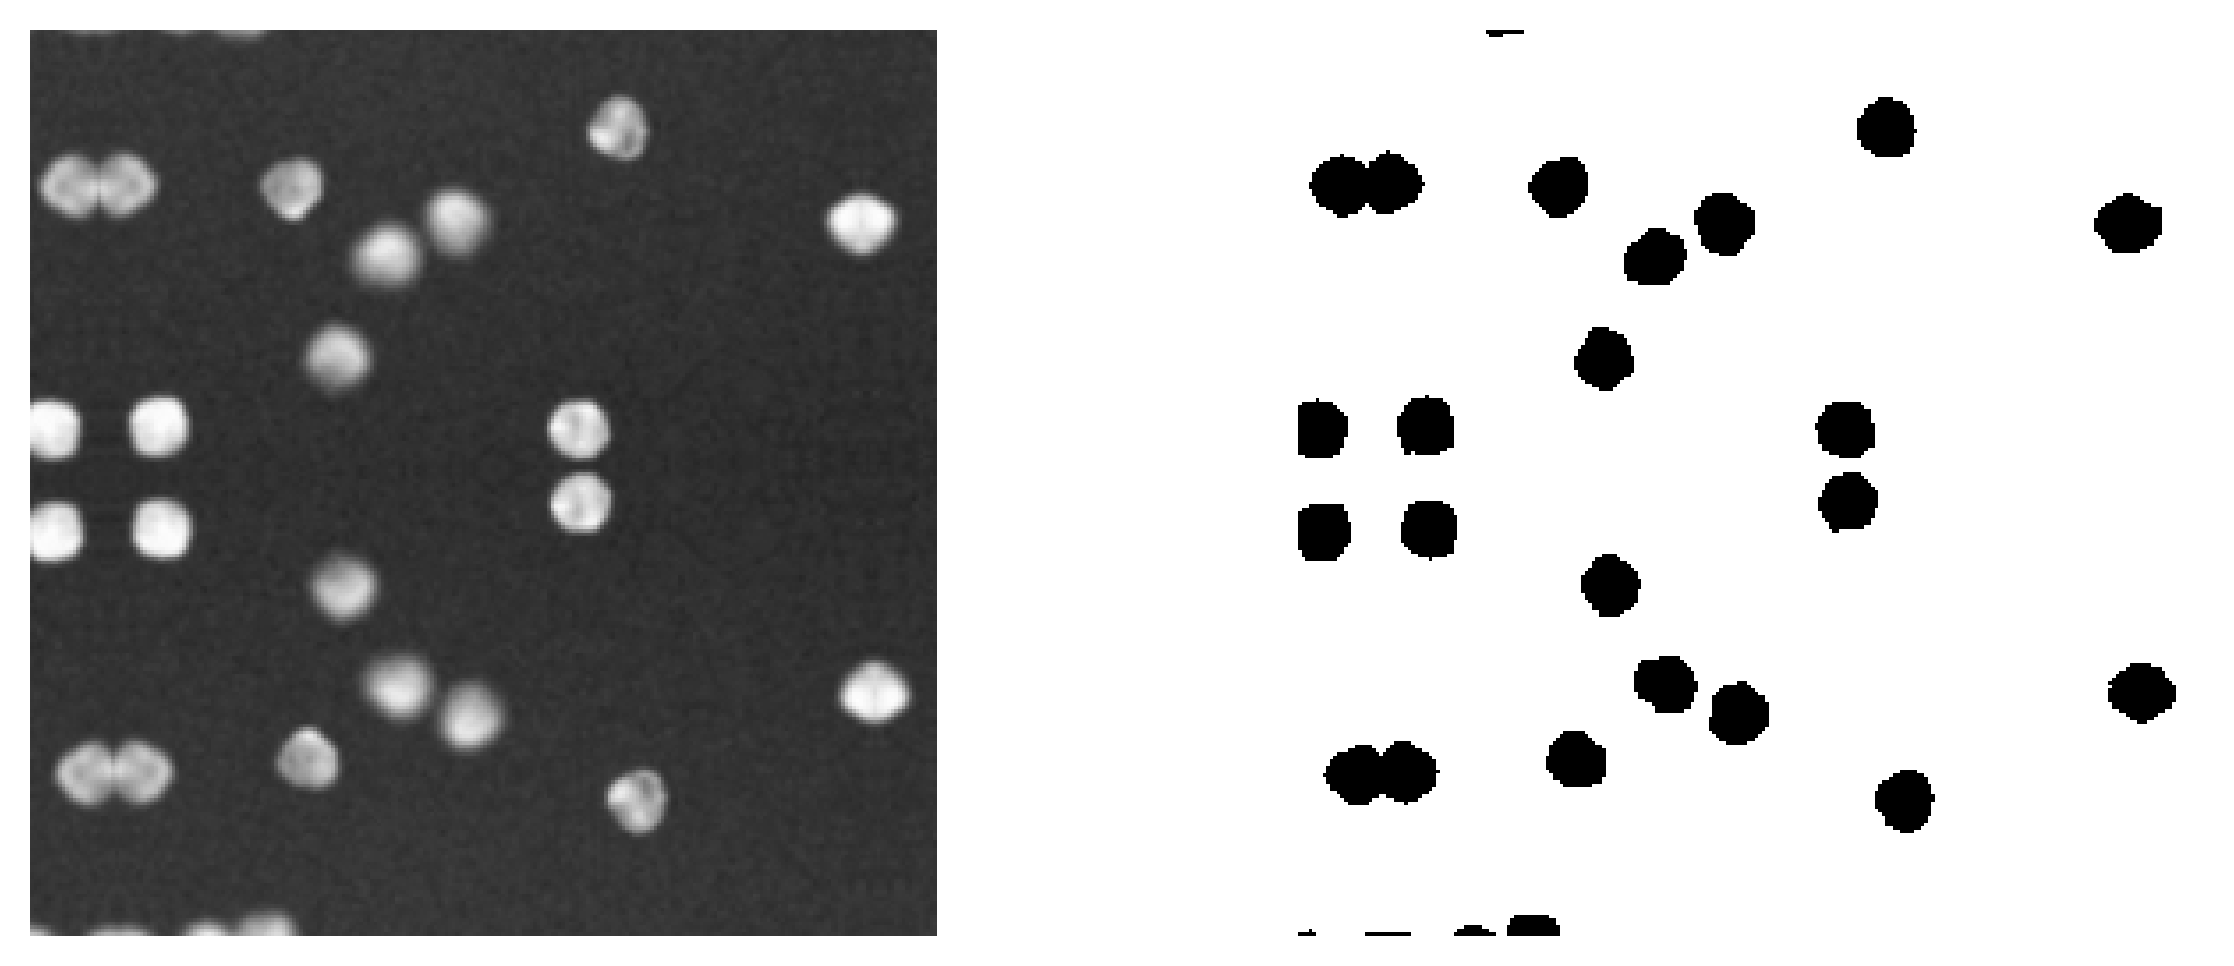

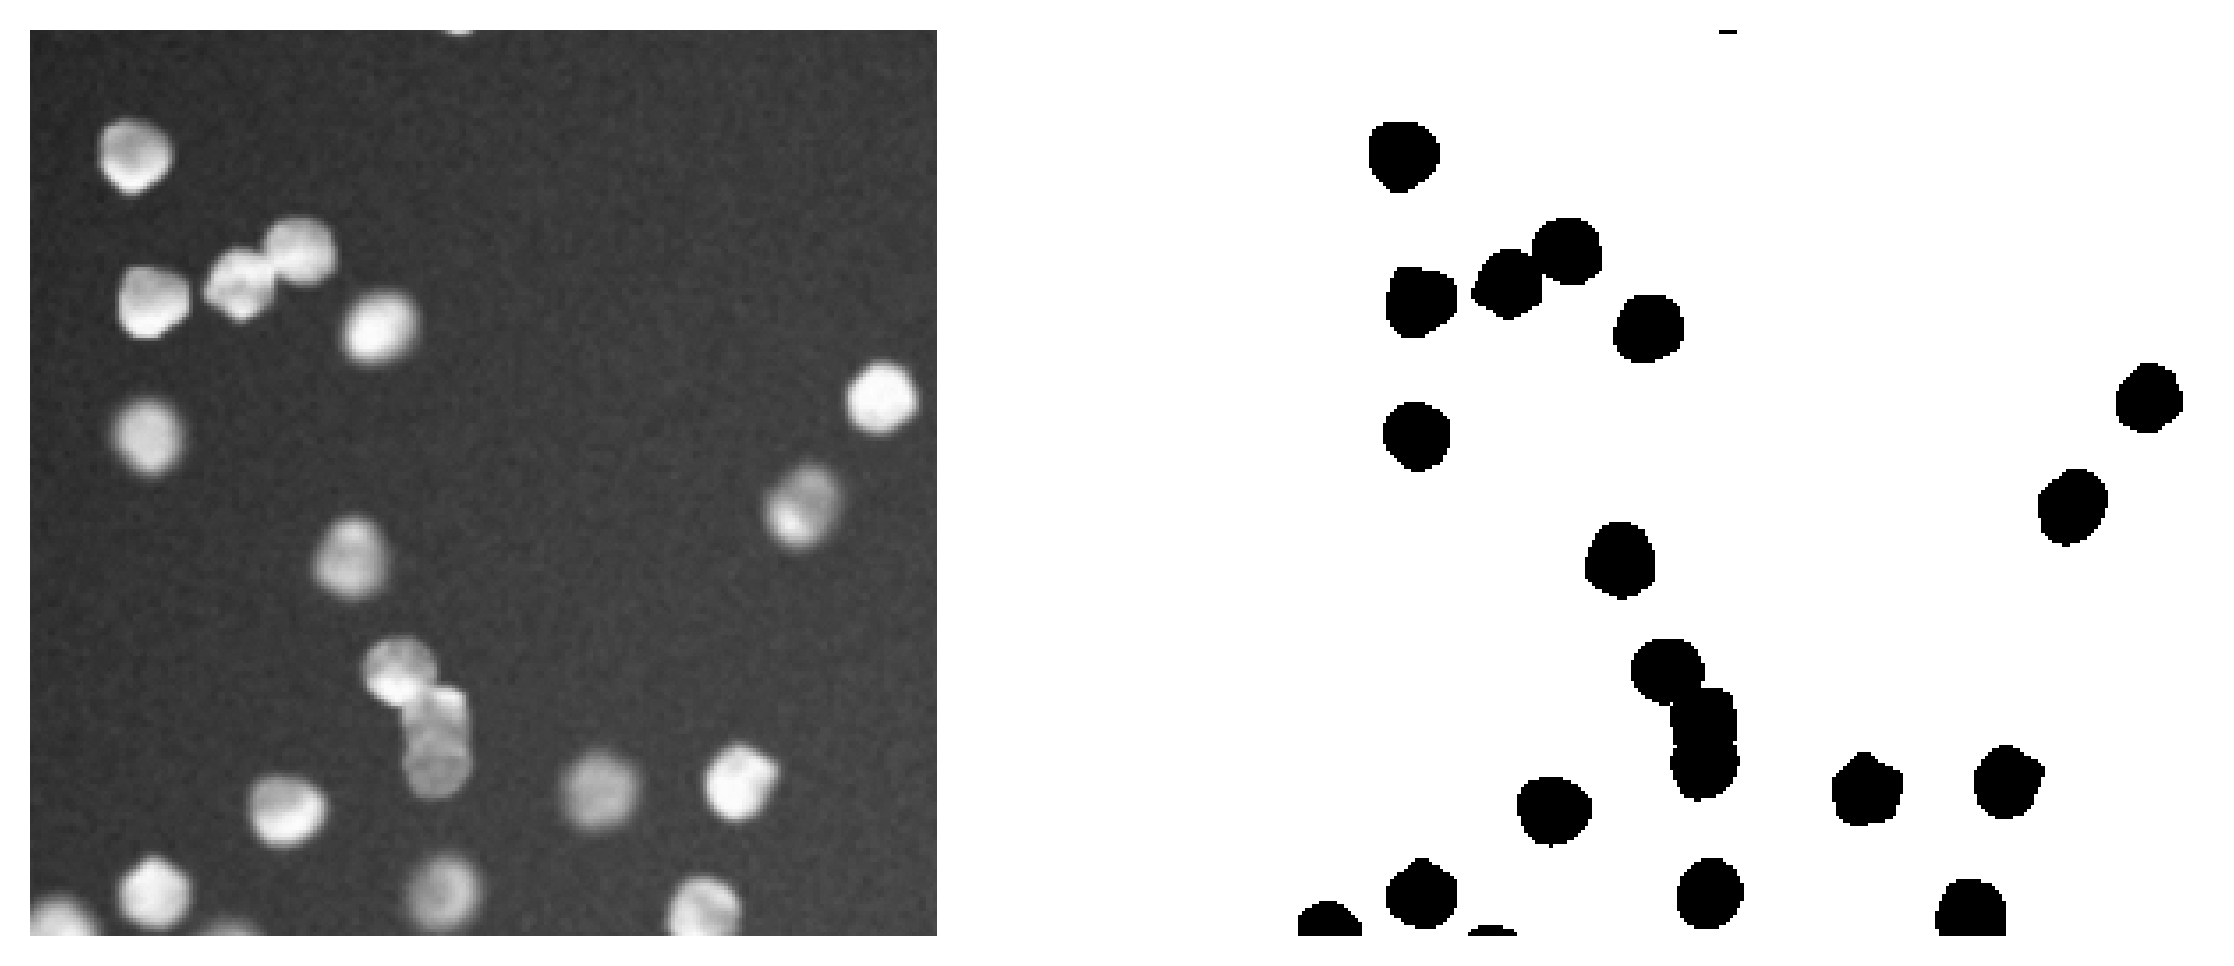

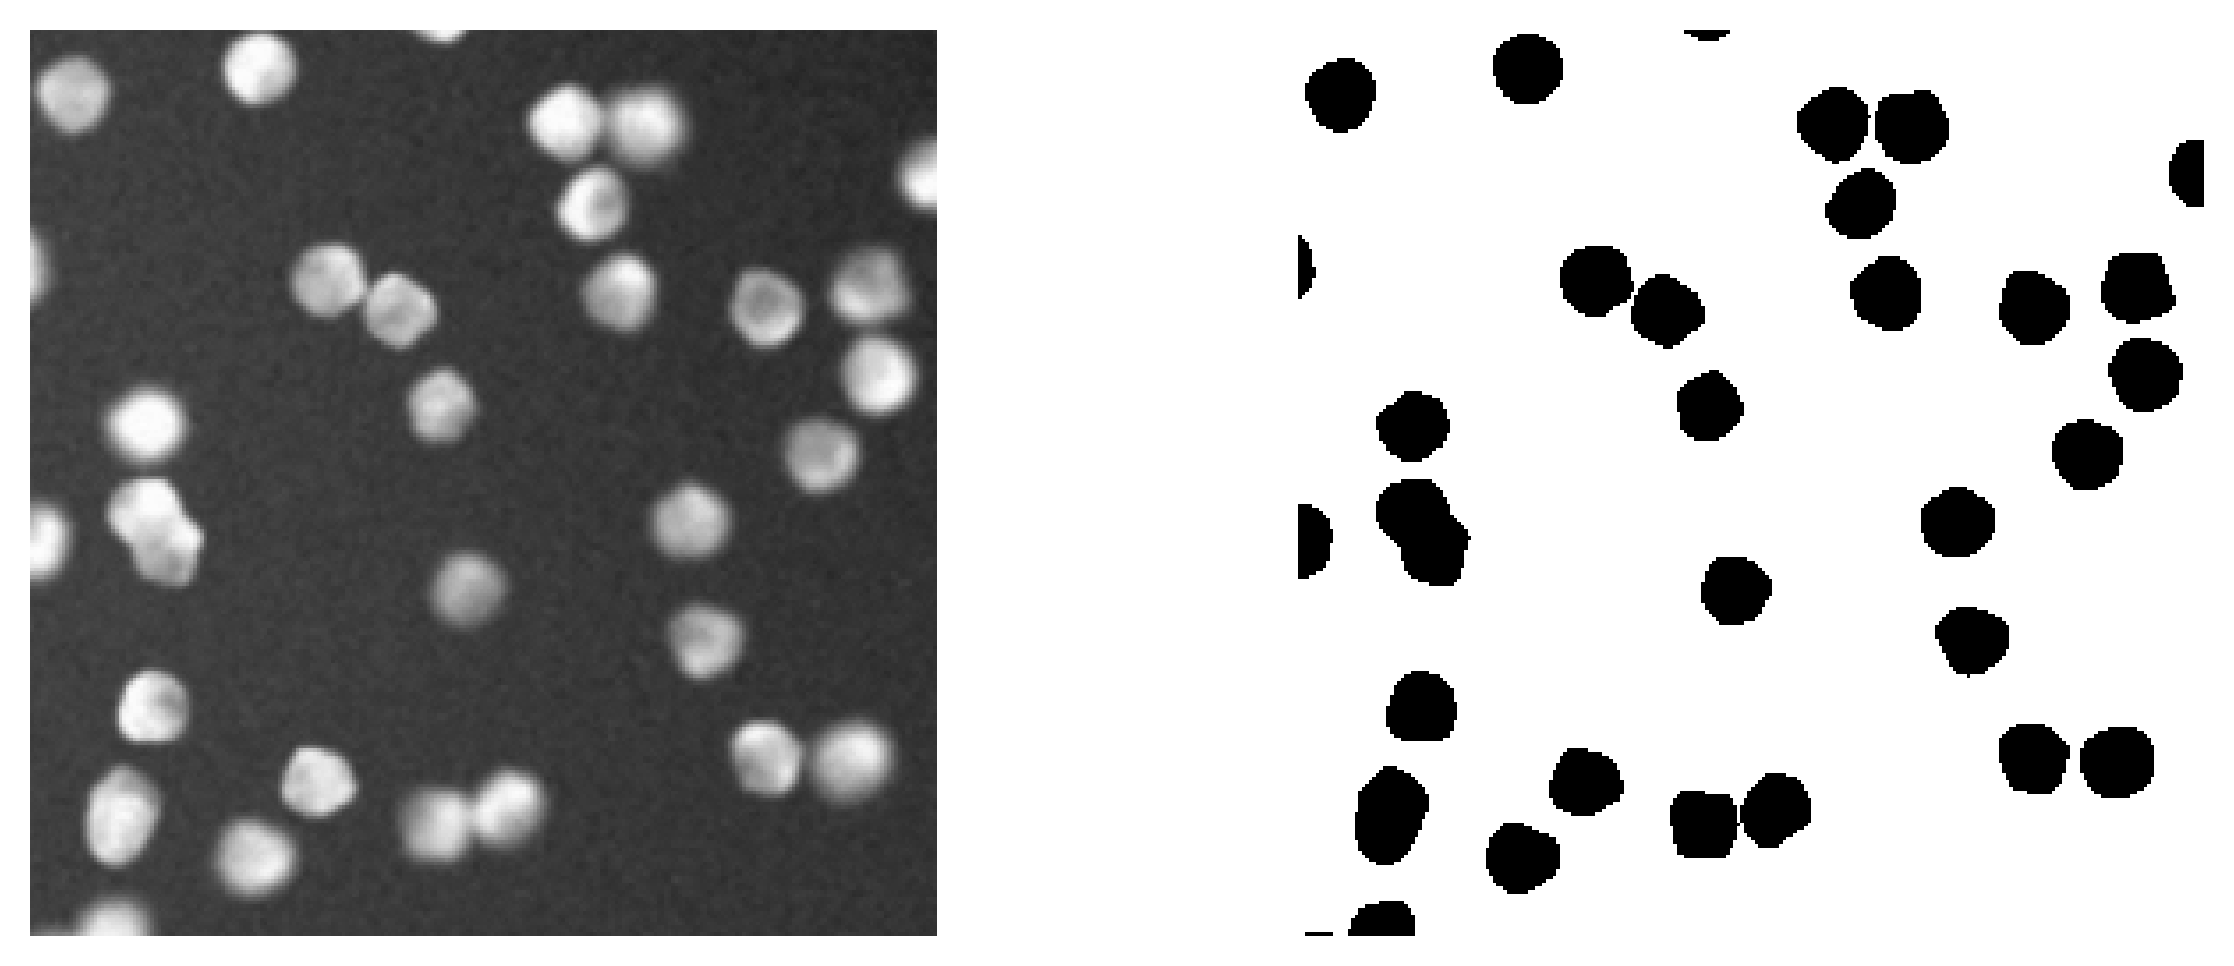

In [111]:
for j in np.random.randint(16, size=3):
    plt.figure(dpi=300, figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(imgs[j], cmap='Greys')
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow(masks[j, ..., 0], cmap='Greys')

# Neural network architecture

# Neural network training

In [108]:
best_w = keras.callbacks.ModelCheckpoint(
    'unet_best.h5',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode='auto',
    period=1
)

last_w = keras.callbacks.ModelCheckpoint(
    'unet_last.h5',
    monitor='val_loss',
    verbose=0,
    save_best_only=False,
    save_weights_only=True,
    mode='auto',
    period=1
)


callbacks = [best_w, last_w]



adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


model.compile(adam, 'binary_crossentropy')

NameError: ignored

In [ ]:
batch_size = 16
model.fit_generator(
    keras_generator(train_df, batch_size),
    steps_per_epoch=100,
    epochs=100,
    verbose=1,
    callbacks=callbacks,
    validation_data=keras_generator(val_df, batch_size),
    validation_steps=50,
    class_weight=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    shuffle=True,
    initial_epoch=0
)